In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
csv_file_path = '../../dataset/aug_splits/1/val.csv'
pic_dir_path = '../../dataset/pictures'

In [3]:
df = pd.read_csv(csv_file_path)
df.head()

,fname,ammonia,chlorophyll,quality,ammonia_bin
0,../../dataset/pics/2020_02_20_3_Treat7_NoBag_2...,3.39,61.36,3,0
1,../../dataset/pics/augs/0-2020_02_20_3_Treat7_...,3.39,61.36,3,0
2,../../dataset/pics/augs/1-2020_02_20_3_Treat7_...,3.39,61.36,3,0
3,../../dataset/pics/augs/2-2020_02_20_3_Treat7_...,3.39,61.36,3,0
4,../../dataset/pics/augs/3-2020_02_20_3_Treat7_...,3.39,61.36,3,0


In [4]:
from agroalimentary_quality_control.modeling.dataset import RocketDataset, ContrastiveRocketDataset
from agroalimentary_quality_control.modeling.regressor import RocketRegressor

In [5]:
dataset = RocketDataset(df, 'ammonia', 'fname', 0.5)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [6]:
model = RocketRegressor(1081, '../models/pretrained/mobilenet_v2_weights_best_acc.tar', 'cpu')

  0%|          | 0/81 [00:00<?, ?it/s]

torch.Size([8, 3, 384, 512])
torch.Size([8, 1])
torch.Size([8, 1])


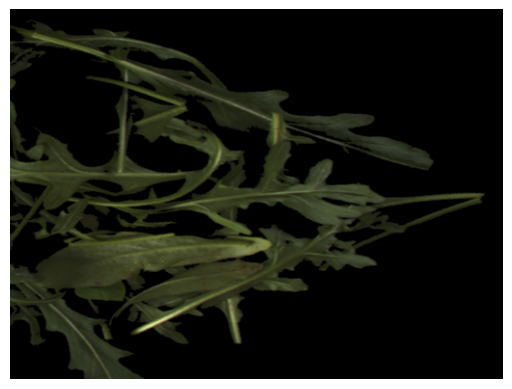

  0%|          | 0/81 [00:07<?, ?it/s]


In [7]:
for image, target in tqdm(loader):
    print(image.shape)
    pred, _ = model(image)
    print(pred.shape)
    print(target.shape)
    
    pic = image[0]
    pic = pic.permute(1, 2, 0)
    plt.imshow(pic.numpy())
    plt.axis('off')
    plt.show()
    
    break


In [62]:
import torch


def binning(target):
    quantiles = torch.quantile(target, torch.linspace(0, 1, steps=4))  # 5 steps for 4 bins
    bin_edges = quantiles.tolist()


    # Use torch.bucketize to find the bin index for each target element
    bin_indices = torch.bucketize(target, torch.tensor(bin_edges))

    return bin_indices

bin_indices = binning(target)

# Now you can query the bins directly using bin_indices
for i in range(4):
    print(target[bin_indices == i])


tensor([1.6400])
tensor([5.4800, 8.0900])
tensor([12.1900, 20.0200])
tensor([202.8200, 215.7700, 253.2300])


In [60]:
bin_indices

tensor([[1],
        [0],
        [2],
        [3],
        [3],
        [2],
        [1],
        [3]])

In [65]:
(bin_indices + 2) % 4

tensor([[3],
        [2],
        [0],
        [1],
        [1],
        [0],
        [3],
        [1]])

In [ ]:
image[bin_indices]

torch.Size([8, 1, 3, 384, 512])

In [71]:
image.shape

torch.Size([8, 3, 384, 512])

In [106]:
num_bins = 4

for images, targets in tqdm(loader):
    quantiles = torch.quantile(targets, torch.linspace(0, 1, steps=num_bins))  # 5 steps for 4 bins
    bin_edges = quantiles.tolist()
    bin_indices = torch.bucketize(targets, torch.tensor(bin_edges))
    negative_bin_indices = (bin_indices + 2) % num_bins

    anchors = []
    negatives = []

    for i in range(len(images)):
        # Get the current bin and negative bin for the current image
        anchor_bin = bin_indices[i]
        negative_bin = negative_bin_indices[i]
        
        # Select a random anchor and a random negative from the corresponding bins
        anchor_indices = torch.where(bin_indices == anchor_bin)[0]
        negative_indices = torch.where(bin_indices == negative_bin)[0]
        
        # Randomly pick an anchor and a negative
        anchor_idx = anchor_indices[torch.randint(0, len(anchor_indices), (1,))]
        negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]
        
        # Fetch the selected anchor and negative images
        # Use direct indexing without extra dimensions
        anchor_image = images[anchor_idx].squeeze(0)  # Remove the singleton dimension
        negative_image = images[negative_idx].squeeze(0)  # Remove the singleton dimension
        
        # Append the anchor and negative to the respective lists
        anchors.append(anchor_image)
        negatives.append(negative_image)

    # Convert the list of anchors and negatives into tensors
    anchors = torch.stack(anchors)  # Shape: (total_count, c, h, w)
    negatives = torch.stack(negatives)  # Shape: (total_count, c, h, w)


100%|██████████| 81/81 [05:38<00:00,  4.17s/it]


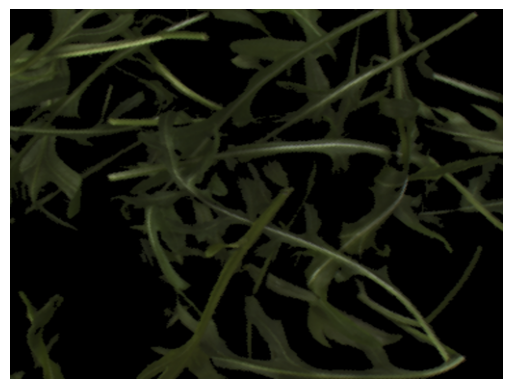

In [107]:
pic = images[0]
pic = pic.permute(1, 2, 0)
plt.imshow(pic.numpy())
plt.axis('off')
plt.show()

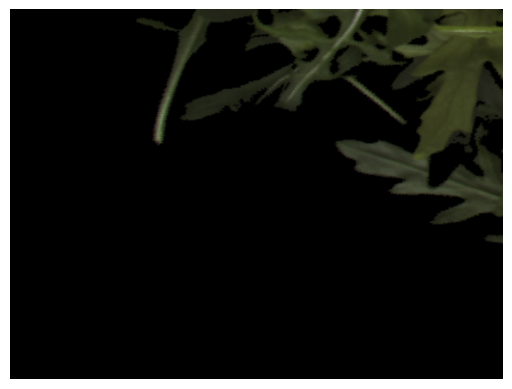

In [108]:
pic = anchors[0]
pic = pic.permute(1, 2, 0)
plt.imshow(pic.numpy())
plt.axis('off')
plt.show()

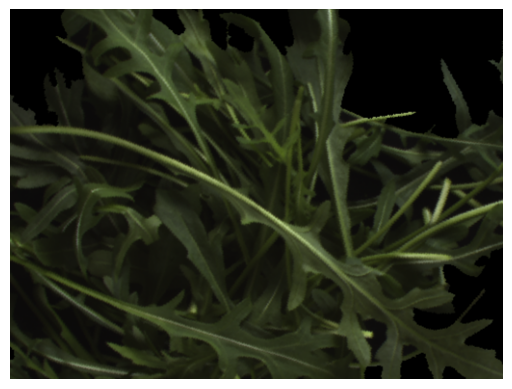

In [109]:
pic = negatives[0]
pic = pic.permute(1, 2, 0)
plt.imshow(pic.numpy())
plt.axis('off')
plt.show()